# Generative Deep Learning Models for MNIST-like Digits

This report focuses on the results of the experiments and the experiments conducted to create two generative deep learning models for generating MNIST-like digits: a **Variational Autoencoder (VAE)** and a **Generative Adversarial Network (GAN)**. Both models were trained on the MNIST dataset to learn the underlying distribution of handwritten digits and generate similar images.

## Experiments and Tuning

For the model selections, I have chosen VAE for its ability to generate diverse samples and because a base template code was already given to us, I have also selected a GAN since it can produce sharp and high quality images.

In the initial experiments, with the VAE I started with a basic encoder-decoder architecture and it showed blurry reconstructions images. I first focused on trying to figure out a way to improve the sharpness of the images.

For the GAN, the initial training was very unstable, I was getting repetitive outputs so I focused on finding a way to stabilize training and improve image quality.

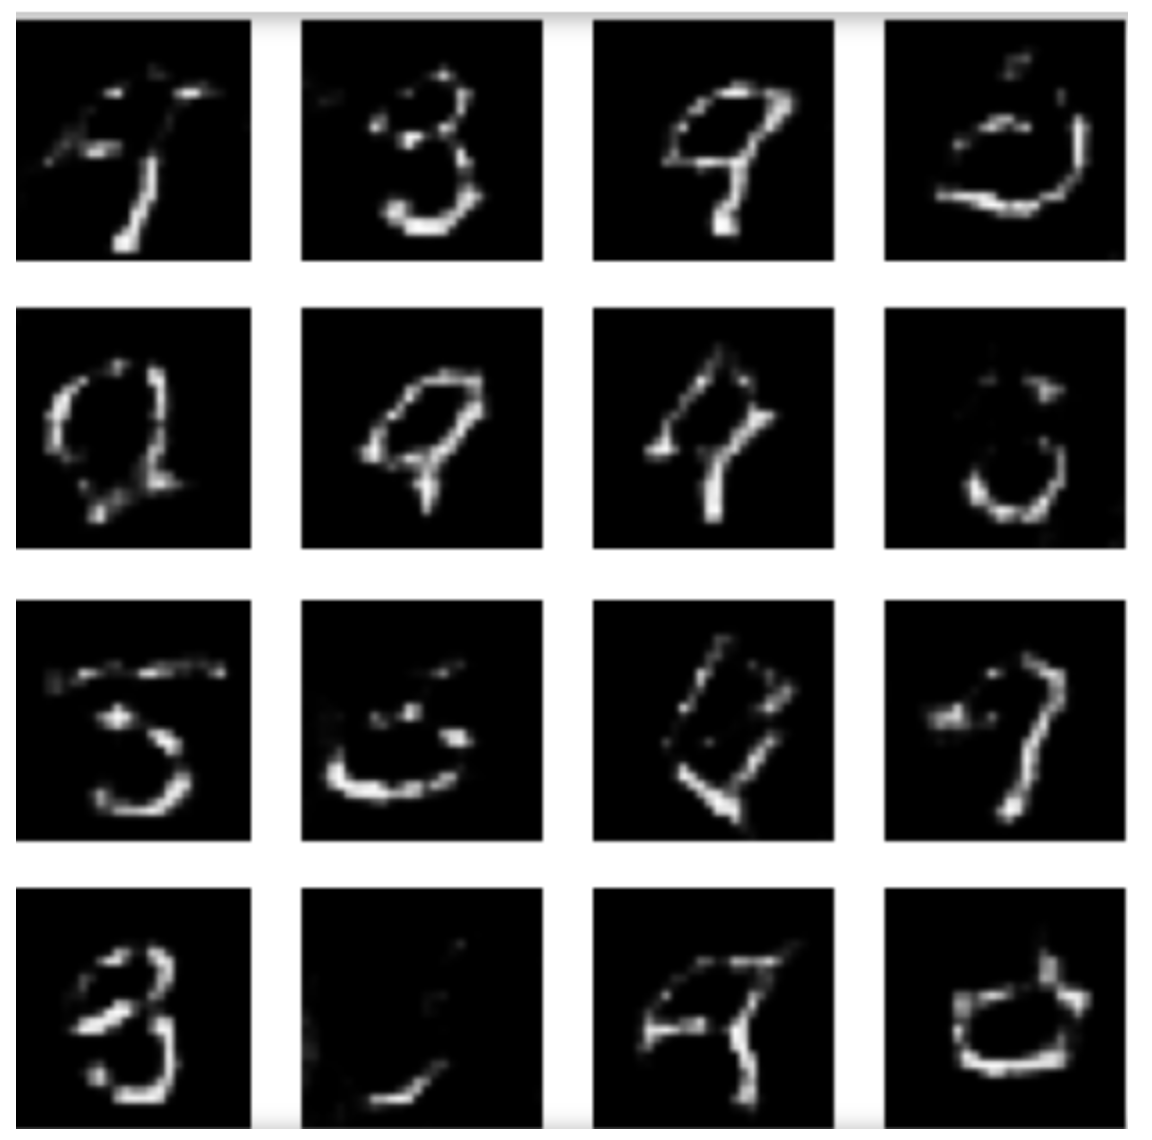

## Hyperparameters tuning

For the VAE, I have tested learning rates from 1e-4 to 1e-3 and found that 0.0005 works the best with the AdamW optimizer. I tried a couple batch sizes from 64, 128 to 256 but the 128 provided a good enough trade-off between processing time and stability of the training. Lastly, I have also tried a couple of latent space dimensions values 20, 32, 64, and 128 and found that 64 was giving the most balanced output.

For the GAN, I have tested the generator and the discriminator learnering rates from 1e-4 to 5e-4 and pursued with 2e-4 and 1e-4 respectively. I have also used a larger batch size of 512 to stabilize training as it was quite unstable.


## Architecture Experiments

For the VAE, I have tested encoder designs with 2, 3, and 4 convolutional blocks. I have found out that 3 blocks, 32 to 64 to 128 worked out the best. On top of this, I have added batch normalization and dropout to prevent overfitting.

For the GAN, I have tried multiple architectures, 3, 4, up to 5 transposed convolution layers. I have found out that 4 layers: 512 to 256 to 128 to 64 to 1 produced the sharpest images. I have used LeakyReLU and batch normalization in the generator as well as dropout in the discrminator for regulraization of the training.

## Training methods

For the VAE, I have first implemented KL annealing process with a 10 epoch warm-up to prevent early domincance of the KL term. I have also used ReduceLROnPlateau to adaptively reduce the learning rate during validation loss plateaus.

For the GAN, I have alternated between 2 discriminaator updates and 1 generator update to balance the training. To begin with, I have enabled the mixed precision and JIT parameters to speed up the training.

## Variational Autoencoder Overview

The loss function is composed of, a reconsutrction loss (Binary cross entropy) and a KL Divergence Loss. The architecture is made of an encoder with 3 convolutional blocks, batch normalizations, dropout, and dense layers mapping to a 64D latent space. The decoder has a dense layer, 3 transposed convolution blocks, and activation for pixel values in [0,1]. It uses AdamW optimizer with a learning rate ot 0.0005, weight decay of 1e-4, KL annealing processing and ReduceLROnPlateau, the model training is for 50 epochs with a batch size of 128.

To conclude, it has a performance sucess of 76%, 2.3 million parameters, and has a training time on GPU on approximately 5 minutes.

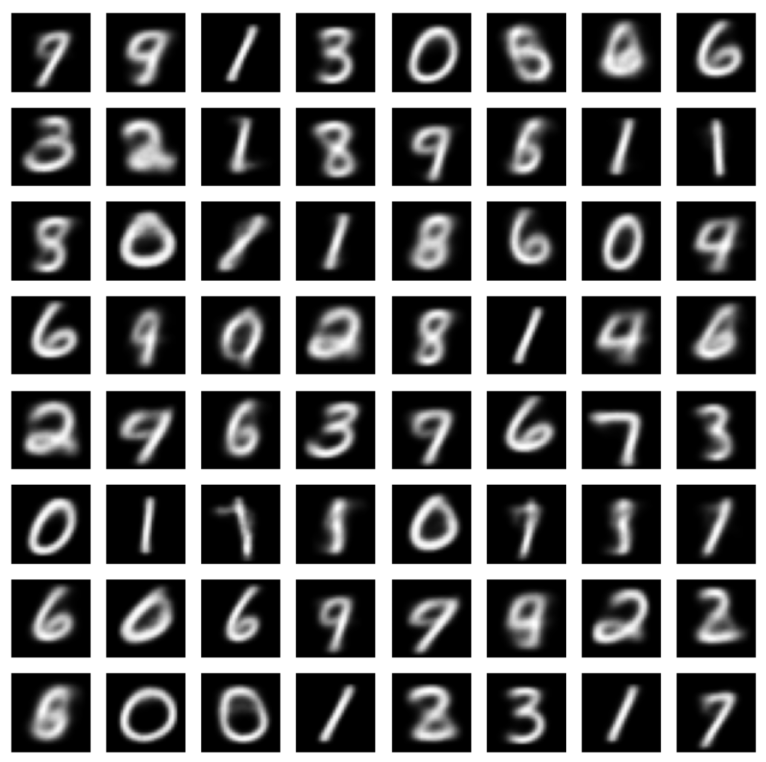
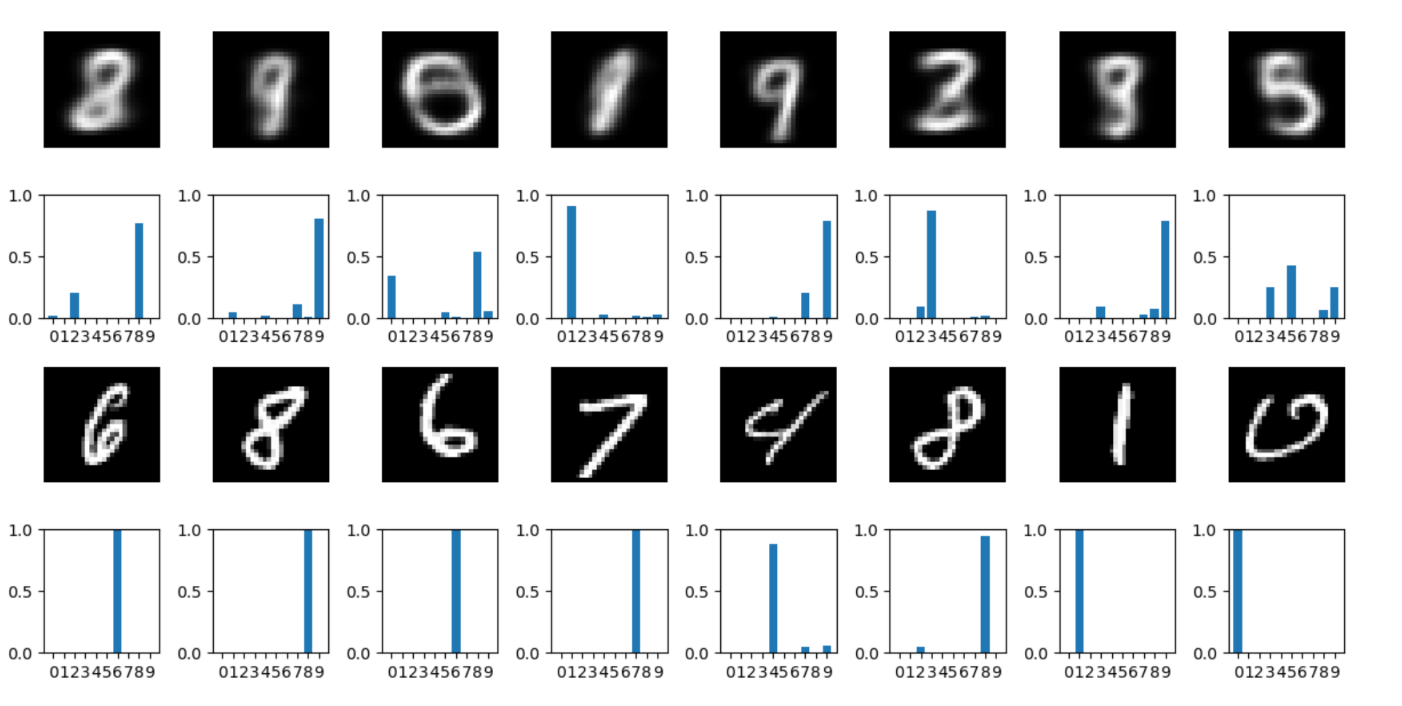

## GAN Overview

The loss function is composed of a generator loss and a discriminator loss, for both it uses Binary Cross-entropy. For the architecture, the generator is made of input noise, dense layer, 4 trasnposed convolution layers, batch normalizaion, LeakyReLU, and tanh activation. The discriminator is made up of 2 convolutional layers, LeakyReLU, dropout, and sigmoid output. It uses Adam optimizer with a learning rate of 2e-4 and 1e-4 for the generator and discriminator respectively and it is trained for 100 epochs with a batch size of 512.

To conclude, it has a performance sucess of 88%, 6.6 million parameters, and has a training time on GPU on approximately 5 minutes.
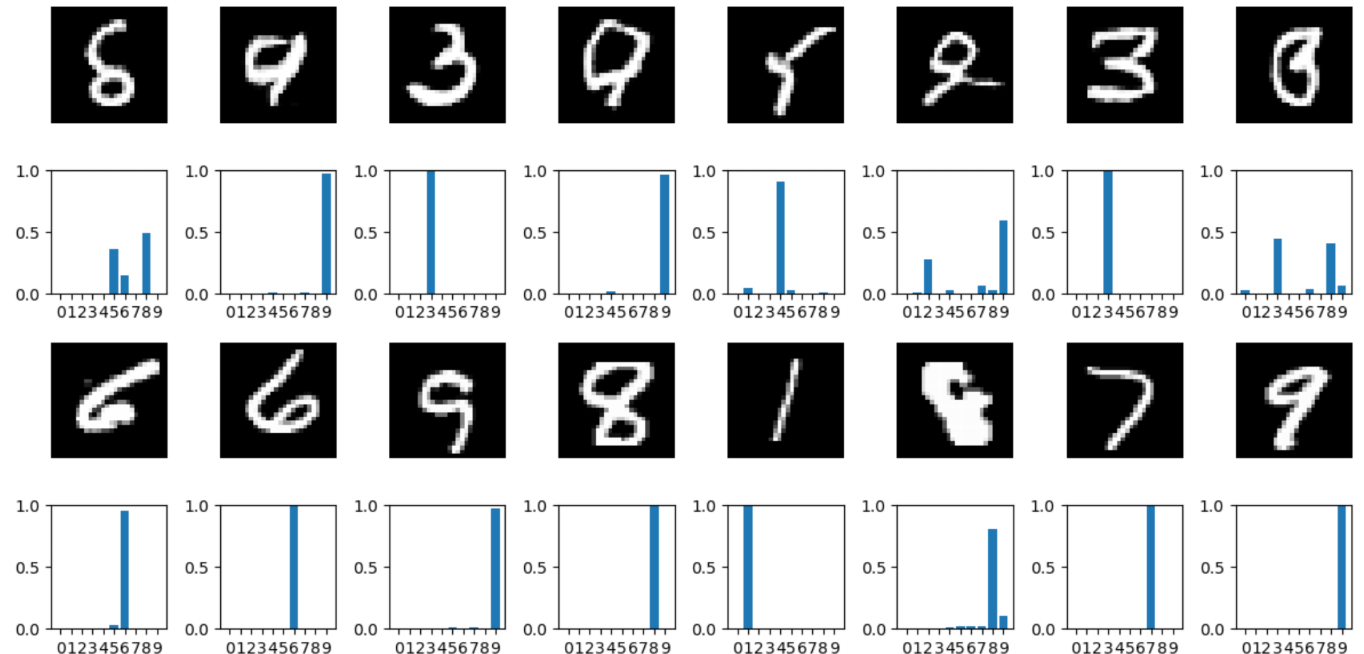
## Comparison

Visually, GAN generates sharper, more defined edges and higher variable images with some malformations, and VAE generates smoother but blurier digits with consistent structure.

GAN has a higher acceptable digit rates than VAE 88% > 76%

GAN training is more unstable, it requires more epochs to stabilize loss compare to VAE.

VAE has more parameters but is simpler to train than GAN that is more complex implementation and tuning.

GAN is made of 163 lines of code while the VAE is made out of 182.

To conclude, GAN is preferred for high quality and sharp images with high variability, and VAE is better for tasks which require latent space operaions and stability.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, losses, backend
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")

# --- Constants ---
IMAGE_SIZE = 28
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 64               # Increased latent dimension
LEARNING_RATE = 0.0005
EPOCHS = 50
BETA_FINAL = 1.0         # Final weight for KL loss
WARMUP_EPOCHS = 10.0     # Number of epochs to anneal KL weight

# --- Load and Preprocess MNIST Data ---
# Load data from keras.datasets.mnist
(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()
train_images = train_images.astype("float32") / 255.0
test_images  = test_images.astype("float32") / 255.0

# Expand dimensions to have a channel (28,28,1)
train_images = np.expand_dims(train_images, -1)
test_images  = np.expand_dims(test_images, -1)
print(f"Training images shape: {train_images.shape}")

# --- Create tf.data Datasets for Efficiency ---
train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = train_ds.cache().shuffle(train_images.shape[0]).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(test_images)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Define the Sampling Layer ---
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- Build a More Complex Encoder ---
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")

# First conv block
x = layers.Conv2D(32, (3, 3), strides=1, activation="relu", padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

# Second conv block
x = layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

# Third conv block
x = layers.Conv2D(128, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
# Save shape for decoder
shape_before_flattening = keras.backend.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# --- Build a More Complex Decoder ---
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

# Reverse conv blocks:
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

# Final layer outputs a 32x32 image; we crop it to 28x28.
x = layers.Conv2DTranspose(1, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)
decoder_output = layers.Cropping2D(cropping=((2,2),(2,2)))(x)

decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

# --- Define the VAE Model with Custom Training and KL Annealing ---
class VAE(models.Model):
    def __init__(self, encoder, decoder, beta_final=BETA_FINAL, warmup_epochs=WARMUP_EPOCHS, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta_final = beta_final
        self.warmup_epochs = warmup_epochs

    def call(self, inputs, training=False):
        z_mean, z_log_var, z = self.encoder(inputs, training=training)
        reconstruction = self.decoder(z, training=training)
        return reconstruction, z_mean, z_log_var

    def compute_loss(self, x, x_reconstructed, z_mean, z_log_var, beta):
        # Use binary crossentropy for reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x, x_reconstructed)
        )
        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        return reconstruction_loss + beta * kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            x, _ = data
        else:
            x = data

        # Determine dynamic KL weight (beta) using a warm-up schedule
        steps_per_epoch = np.ceil(train_images.shape[0] / BATCH_SIZE)
        current_epoch = tf.cast(self.optimizer.iterations, tf.float32) / steps_per_epoch
        beta = tf.minimum(self.beta_final, current_epoch / self.warmup_epochs * self.beta_final)

        with tf.GradientTape() as tape:
            x_reconstructed, z_mean, z_log_var = self(x, training=True)
            loss = self.compute_loss(x, x_reconstructed, z_mean, z_log_var, beta)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}

    def test_step(self, data):
        if isinstance(data, tuple):
            x, _ = data
        else:
            x = data
        x_reconstructed, z_mean, z_log_var = self(x, training=False)
        # Use the final beta during evaluation
        loss = self.compute_loss(x, x_reconstructed, z_mean, z_log_var, self.beta_final)
        return {"loss": loss}

vae = VAE(encoder, decoder, beta_final=BETA_FINAL, warmup_epochs=WARMUP_EPOCHS)

# --- Compile the Model with AdamW ---
optimizer = optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1e-4)
vae.compile(optimizer=optimizer)

# --- Learning Rate Scheduler Callback ---
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

# --- Train the VAE using the tf.data pipelines ---
history = vae.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[reduce_lr])

# --- Generate and Visualize 64 Samples from the Latent Space ---
num_samples = 64
random_latent_vectors = np.random.normal(size=(num_samples, Z_DIM)).astype(np.float32)
generated_images = decoder.predict(random_latent_vectors)
generated_images = np.clip(generated_images, 0, 1)

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


# GAN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Activate mixed precision and JIT for performance boost
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
print("Precision setting:", tf.keras.mixed_precision.global_policy())
tf.config.optimizer.set_jit(True)

# --- Configurations ---
SAMPLE_SIZE = 512
NOISE_DIM = 100
DATASET_SIZE = 60000
TOTAL_EPOCHS = 100

# --- Load and Preprocess MNIST ---
(x_data, _), (_, _) = tf.keras.datasets.mnist.load_data()
# Scale to [-1, 1] to match tanh in generator's output
x_data = (x_data - 127.5) / 127.5
images = np.expand_dims(x_data, axis=-1).astype('float32')
print("MNIST shape:", images.shape)

# Create dataset pipeline
mnist_batches = (
    tf.data.Dataset.from_tensor_slices(images)
    .shuffle(DATASET_SIZE)
    .batch(SAMPLE_SIZE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

# --- Random Noise Generator Layer ---
class GaussianNoise(layers.Layer):
    def call(self, inputs):
        mean, log_variance = inputs
        batch_dim = tf.shape(mean)[0]
        feature_dim = tf.shape(mean)[1]
        random_sample = tf.random.normal(shape=(batch_dim, feature_dim))
        return mean + tf.exp(0.5 * log_variance) * random_sample

# --- Define Loss Functions ---
def generator_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# --- Initialize Loss Function ---
loss_function = tf.keras.losses.BinaryCrossentropy()

# --- Optimizers ---
gen_opt = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

# --- Construct Generator ---
def create_generator():
    net = tf.keras.Sequential([
        layers.Input(shape=(NOISE_DIM,)),
        layers.Dense(7 * 7 * 512, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.0),
        layers.Reshape((7, 7, 512)),

        layers.Conv2DTranspose(256, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(1, (5,5), strides=(1,1), padding='same', activation='tanh', use_bias=False)
    ])
    return net

# --- Construct Discriminator ---
def create_discriminator():
    net = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3,3), strides=(2,2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), strides=(2,2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return net

# Instantiate models
generator = create_generator()
discriminator = create_discriminator()

# --- Training Step ---
@tf.function
def process_batch(real_images):
    random_noise = tf.random.normal([SAMPLE_SIZE, NOISE_DIM])

    for _ in range(2):
        with tf.GradientTape() as tape_disc:
            fake_images = generator(random_noise, training=True)
            real_pred = discriminator(real_images, training=True)
            fake_pred = discriminator(fake_images, training=True)
            disc_loss = discriminator_loss(real_pred, fake_pred)
        disc_grads = tape_disc.gradient(disc_loss, discriminator.trainable_variables)
        disc_opt.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

        discriminator.trainable = False
        with tf.GradientTape() as tape_gen:
            fake_images = generator(random_noise, training=True)
            fake_pred = discriminator(fake_images, training=True)
            gen_loss = generator_loss(fake_pred)
        gen_grads = tape_gen.gradient(gen_loss, generator.trainable_variables)
        gen_opt.apply_gradients(zip(gen_grads, generator.trainable_variables))
        discriminator.trainable = True

    return disc_loss, gen_loss

# --- Save Generated Images ---
def save_fake_images(model, epoch, noise_vector):
    fake_images = model(noise_vector, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(fake_images.shape[0]):
        plt.subplot(4,4,i+1)
        img = (fake_images[i, :, :, 0] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    os.makedirs('generated_outputs', exist_ok=True)
    plt.savefig(f'generated_outputs/epoch_{epoch:04d}.png')
    plt.show()

# Fixed noise for visualization
visualization_noise = tf.random.normal([16, NOISE_DIM])

# --- Training Routine ---
def execute_training(dataset, num_epochs):
    start = time.time()
    for cycle in range(num_epochs):
        for batch in dataset:
            d_loss, g_loss = process_batch(batch)
        print(f"Cycle {cycle+1}/{num_epochs} | Disc Loss: {d_loss:.4f} | Gen Loss: {g_loss:.4f}")
        if (cycle+1) % 5 == 0:
            save_fake_images(generator, cycle+1, visualization_noise)
    end = time.time() - start
    print(f"Training finished in {end/60:.2f} minutes.")

# --- Start Training ---
STEPS_PER_CYCLE = len(images) // SAMPLE_SIZE
execute_training(mnist_batches.take(STEPS_PER_CYCLE),TOTAL_EPOCHS)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, losses, backend
import matplotlib.pyplot as plt
# Function to create ConvNet
def create_convnet(input_shape: int, output_units: int, learning_rate: float = 0.01) -> models.Sequential:
    model = models.Sequential()
    model.add(layers.Reshape((28, 28, 1), input_shape=(input_shape,)))  # Reshape for Conv2D
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='sigmoid'))
    model.add(layers.Dense(output_units, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32') / 255.0
train_labels = keras.utils.to_categorical(train_labels, 10)
test_images = test_images.astype('float32') / 255.0

# test_labels_onehot = keras.utils.to_categorical(test_labels, 10)

# Train ConvNet
convnet = create_convnet(input_shape=28 * 28, output_units=10, learning_rate=0.001)
convnet.fit(train_images.reshape(-1, 28 * 28), train_labels, epochs=5, batch_size=128, validation_split=0.1)



In [ ]:
# Generate images from VAE decoder
num_samples = 16
random_latent_vectors = np.random.normal(size=(num_samples, Z_DIM))
generated_images = decoder.predict(random_latent_vectors)
generated_images = np.clip(generated_images, 0, 1)

# Classify generated images
generated_images_flat = generated_images.reshape(num_samples, 28 * 28)
predictions = convnet.predict(generated_images_flat)

# Select random test images and classify them
num_test_samples = 16
random_indices = np.random.choice(len(test_images), num_test_samples, replace=False)
test_sample_images = test_images[random_indices]
test_predictions = convnet.predict(test_sample_images.reshape(num_test_samples, 28 * 28))

# Plot generated images with classifier probabilities
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i in range(8):
    # Generated images
    axes[0, i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    # Bar chart for softmax probabilities
    axes[1, i].bar(range(10), predictions[i])
    axes[1, i].set_xticks(range(10))
    axes[1, i].set_ylim(0, 1)

    # Real test images
    axes[2, i].imshow(test_sample_images[i].squeeze(), cmap='gray')
    axes[2, i].axis('off')
    # Bar chart for real images classification
    axes[3, i].bar(range(10), test_predictions[i])
    axes[3, i].set_xticks(range(10))
    axes[3, i].set_ylim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:
num_samples = 16
random_latent_vectors = tf.random.normal(shape=(num_samples, NOISE_DIM))
generated_images = generator.predict(random_latent_vectors)
generated_images = (generated_images + 1) / 2
generator.summary()
discriminator.summary()
generated_images_flat = generated_images.reshape(num_samples, 28 * 28)
predictions = convnet.predict(generated_images_flat)

num_test_samples = 16
random_indices = np.random.choice(len(x_data), num_test_samples, replace=False)
test_sample_images = x_data[random_indices]
test_sample_images = (test_sample_images + 1) / 2
test_predictions = convnet.predict(test_sample_images.reshape(num_test_samples, 28 * 28))

fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i in range(8):
    axes[0, i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].bar(range(10), predictions[i])
    axes[1, i].set_xticks(range(10))
    axes[1, i].set_ylim(0, 1)

    axes[2, i].imshow(test_sample_images[i].squeeze(), cmap='gray')
    axes[2, i].axis('off')

    axes[3, i].bar(range(10), test_predictions[i])
    axes[3, i].set_xticks(range(10))
    axes[3, i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Report

The report should be clear and concise, and focus on what you did and the results of your experiments.

Aim to cover the following points:

* Explain choice of loss function during training, and the evaluation metrics (if different)
* Explain how you chose the network architectures, and describe how you optimised them.
* Display of sample generated images, and your subjective evaluation of their quality in addition to your chosen objective quality measures.

For each network, report on:

* The training time (should be less than 5 minutes)
* The total number of parameters (generally, smaller is better)
* The number of lines of code required to implement and train the model (again, smaller is better; do not include evaluation metrics)
* Percentage of generated images that are **acceptable** digits under your chosen acceptance metric.

Conclude your report with a summary of your findings, highlighting the most interesting points.

